Install packages

In [1]:
!git clone https://github.com/stefanknegt/Probabilistic-Unet-Pytorch.git

Cloning into 'Probabilistic-Unet-Pytorch'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Unpacking objects: 100% (66/66), done.


In [2]:
import sys
sys.path.append('Probabilistic-Unet-Pytorch/')

In [3]:

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='133XNGEsOPEqU9JNaCIfslN2LfnhTeLDD',
                                    dest_path='/content/data-faultseg.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
!unzip "./data/train/fault.zip" -d "data/train/"

Archive:  ./data/train/fault.zip
   creating: data/train/fault/
  inflating: data/train/fault/58.dat  
  inflating: data/train/fault/64.dat  
  inflating: data/train/fault/70.dat  
  inflating: data/train/fault/165.dat  
  inflating: data/train/fault/171.dat  
  inflating: data/train/fault/159.dat  
  inflating: data/train/fault/158.dat  
  inflating: data/train/fault/170.dat  
  inflating: data/train/fault/164.dat  
  inflating: data/train/fault/71.dat  
  inflating: data/train/fault/65.dat  
  inflating: data/train/fault/59.dat  
  inflating: data/train/fault/9.dat  
  inflating: data/train/fault/73.dat  
  inflating: data/train/fault/199.dat  
  inflating: data/train/fault/67.dat  
  inflating: data/train/fault/172.dat  
  inflating: data/train/fault/166.dat  
  inflating: data/train/fault/98.dat  
  inflating: data/train/fault/167.dat  
  inflating: data/train/fault/99.dat  
  inflating: data/train/fault/173.dat  
  inflating: data/train/fault/198.dat  
  inflating: data/train/faul

Download seismic and interpretations:

In [3]:
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt

from probabilistic_unet import ProbabilisticUnet
from utils import l2_regularisation
from tqdm.auto import tqdm, trange

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

Overall parametrization

In [4]:
lr = 1e-5
epochs = 1000
save_every_steps = 5
batch_size = 16

# Architecture parameters:
beta = 30.0
no_convs_fcomb = 2
latent_dim = 4
num_filters = [8,16,32,64]

This is Xinming Wu's keras dataloader:

In [5]:
import os
class MyDataset(Dataset):
    def __init__(self, dpath,fpath, dim = (128, 128, 128)):
        self.dpath = dpath
        self.fpath = fpath
        self.dim = dim
        dpath_files = os.listdir(dpath)
        fpath_files = os.listdir(fpath)
        assert dpath_files == fpath_files
        self.volumes = []
        for fname in dpath_files:
            d = np.fromfile(os.path.join(self.dpath, fname),dtype=np.single)
            f = np.fromfile(os.path.join(self.fpath, fname),dtype=np.single)
            d = d.reshape(1, *dim)
            f = f.reshape(1, *dim)
            self.volumes.append([d, f])
    def __len__(self):
        return len(self.volumes)
    def __getitem__(self, i):
        x, y = self.volumes[i]
        iln = np.random.choice(self.dim[0])
        x = x[:, iln]
        y = y[:, iln]
        return x, y

In [6]:
# import os
# class MyDataset(Dataset):
#     def __init__(self, dpath,fpath, dim = (128, 128, 128)):
#         self.dpath = dpath
#         self.fpath = fpath
#         self.dim = dim
#         dpath_files = os.listdir(dpath)
#         fpath_files = os.listdir(fpath)
#         assert dpath_files == fpath_files
#         self.dpath_files = dpath_files
#     def __len__(self):
#         return len(self.dpath_files)
#     def __getitem__(self, i):
#         fname = self.dpath_files[i]
#         d = np.fromfile(os.path.join(self.dpath, fname),dtype=np.single)
#         f = np.fromfile(os.path.join(self.fpath, fname),dtype=np.single)
#         x = d.reshape(1, *self.dim)
#         y = f.reshape(1, *self.dim)
#         iln = np.random.choice(self.dim[0])
#         x = x[:, iln]
#         y = y[:, iln]
#         return x, y

In [7]:
seismPathT = "./data/train/seis/"
faultPathT = "./data/train/fault/"

seismPathV = "./data/validation/seis/"
faultPathV = "./data/validation/fault/"

train_generator = MyDataset(dpath=seismPathT,fpath=faultPathT)
valid_generator = MyDataset(dpath=seismPathV,fpath=faultPathV)

In [8]:
x, y = train_generator[0]
x.shape

(1, 128, 128)

In [9]:
train_loader = DataLoader(train_generator, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(valid_generator, batch_size = batch_size, shuffle = True)

In [10]:
x, y = next(iter(train_loader))
x.shape

torch.Size([16, 1, 128, 128])

Now I try to load it with the pytorch dataloader:

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is', device)

device is cuda


In [12]:
class Logger(object):
    def __init__(self):
        self.metrics = ['elbo', 'reconstruction_loss', 'mse_loss', 'std', 'kl divergence', 'reg_loss']
        self.lists = [[], [], [], [], [], []]
        self.steps = []
    def step(self, global_step, *args):
        for i, value in enumerate(args):
            self.lists[i].append(value.item())
        self.steps.append(global_step)

Here we need to adjust the dimensions:

In [13]:
net = ProbabilisticUnet(input_channels=1, 
                        num_classes=1, 
                        num_filters=num_filters, 
                        latent_dim=latent_dim, 
                        no_convs_fcomb=no_convs_fcomb, 
                        beta=beta)
net = net.to(device)

In [14]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
net(x, y, training=True)
net.elbo(y)

/software/all/jupyter/tensorflow/2021-09-30/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor(-130901.1016, device='cuda:0', grad_fn=<NegBackward0>)

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0)
global_step = 0
nsamples = 64
mse_criteria = nn.MSELoss()
logger = Logger()
loggerVal = Logger()

def compute_stats(mask):
    mean_pred = torch.zeros_like(mask)
    mean_sq_pred = torch.zeros_like(mask)
    for _ in range(nsamples):
        pred = net.sample().detach()
        mean_pred += pred
        mean_sq_pred += pred**2
    mean_pred /= nsamples
    mean_sq_pred /= nsamples
    var_pred = (mean_sq_pred - mean_pred**2)
    mse = mse_criteria(mask, mean_pred)
    std = var_pred.mean()**0.5
    return mse, std
    
for epoch in trange(epochs, desc = 'epochs'):
    for step in trange(len(train_loader), desc='batches', leave=False):
        patch, mask = next(iter(train_loader))
        patch = patch.to(device)
        mask = mask.to(device)
        net(patch, mask, training=True)
        elbo = net.elbo(mask)
        reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
        loss = -elbo + 1e-5 * reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if global_step % save_every_steps == 0:
            mse, std = compute_stats(mask)
            logger.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
            
            patch, mask = next(iter(val_loader))
            patch = patch.to(device)
            mask = mask.to(device)
            net(patch, mask, training=False)
            elbo = net.elbo(mask).detach()
            reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
            loss = -elbo + 1e-5 * reg_loss
            mse, std = compute_stats(mask)
            loggerVal.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
        global_step += 1

epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

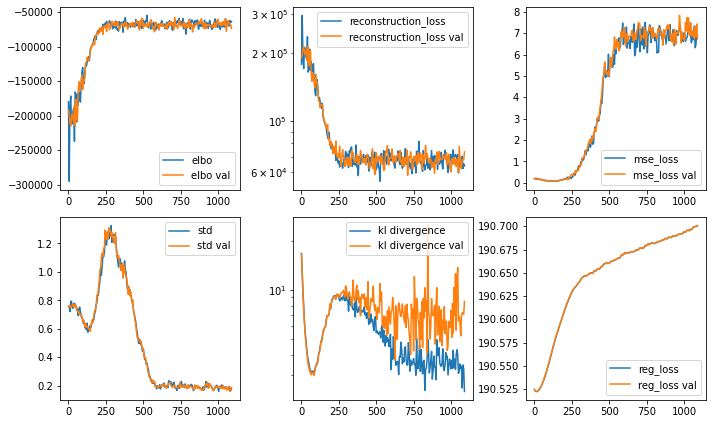

In [18]:
ncols = 3
nrows = len(logger.metrics) // ncols
fig, axs = plt.subplots(figsize = (10, 6), ncols = ncols, nrows = nrows)
for i, name in enumerate(logger.metrics):
    axs.flatten()[i].plot(logger.steps, logger.lists[i], label = name)
    axs.flatten()[i].plot(loggerVal.steps, loggerVal.lists[i], label = name+' val')
    if name in ['kl divergence', 'reconstruction_loss']:
        axs.flatten()[i].set_yscale('log')
    axs.flatten()[i].legend()
plt.tight_layout()

In [29]:
patch, mask = next(iter(train_loader))
net.forward(patch.to(device), None, training=False)

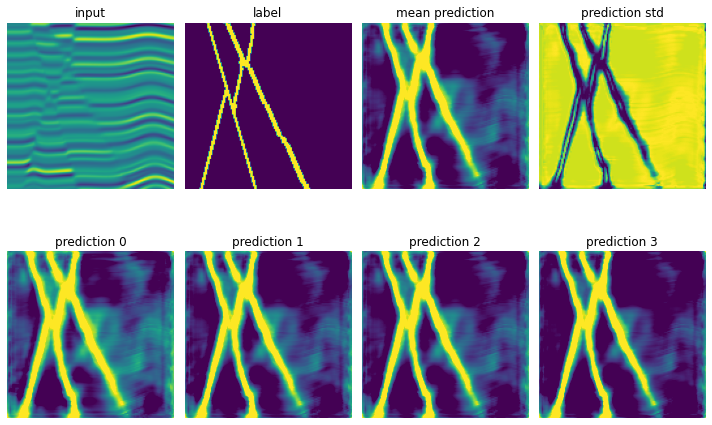

In [30]:
i = np.random.randint(batch_size)

nsamples = 4
ncols = 4
nrows = int(np.ceil((nsamples+3) / ncols))

pred_mask = net.sample().detach().cpu()
vmin = torch.quantile(pred_mask, 0.1)
vmax = torch.quantile(pred_mask, 0.9)

fig, axs = plt.subplots(figsize = (10, 7), ncols = ncols, nrows = nrows)
axs.flatten()[0].imshow(patch[i,0].T)
axs.flatten()[0].axis('off')
axs.flatten()[0].set_title('input')
axs.flatten()[1].imshow(mask[i,0].T)
axs.flatten()[1].axis('off')
axs.flatten()[1].set_title('label')

mean_pred = torch.zeros_like(mask)
mean_sq_pred = torch.zeros_like(mask)
for j in range(nsamples):
    pred_mask = net.sample().detach().cpu()
    mean_pred += pred_mask
    mean_sq_pred += pred_mask**2
    axs.flatten()[j+4].imshow(pred_mask[i,0].T, vmin = vmin, vmax = vmax)
    axs.flatten()[j+4].axis('off')
    axs.flatten()[j+4].set_title(f'prediction {j:d}')
mean_pred /= nsamples
mean_sq_pred /= nsamples
var_pred = (mean_sq_pred - mean_pred**2)
std = var_pred**0.5


axs.flatten()[2].imshow(mean_pred[i,0].T, vmin = vmin, vmax = vmax)
axs.flatten()[2].axis('off')
axs.flatten()[2].set_title(f'mean prediction')

axs.flatten()[3].imshow(std[i,0].T)
axs.flatten()[3].axis('off')
axs.flatten()[3].set_title(f'prediction std')

plt.tight_layout()

In [39]:
print(torch.min(patch), torch.max(patch))

tensor(-5.4464) tensor(3.3386)


In [18]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

In [19]:
!pip install segpy

import segpy
from segpy.reader import create_reader

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 74 kB 470 kB/s eta 0:00:01
     |████████████████████████████████| 49 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 1.4 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13703 sha256=6dafc98e9e0fc8669fc18995c29b637add42a790a7f78d8faee5a6865cf296d4
  Stored in directory: /hkfs/home/project/haicore-project-ws-hip-2021/gfz_wrona/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/hkfs/home/software/all/jupyter/tensorflow/2021-09-30/bin/python3.8 -m pip install --upgrade pip' command.


In [40]:
filename = "Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

#data = (data-np.min(data))/(np.max(data)-np.min(data))

In [41]:
data = data/6000
print(np.min(data), np.max(data))

-5.461166666666666 5.461166666666666


In [76]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,1)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x_max-wsize:x_max]
            elif x_max - x < wsize:
                data_patch[n,:,:,0] = data[t:t+wsize, x_max-wsize:x_max]
            elif t_max - t < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x:x+wsize]
            else:
                data_patch[n,:,:,0] = data[t:t+wsize,x:x+wsize]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,1))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count


dt = 32
dx = 32

size = 128

(_, t_max, x_max) = data.shape


data_tiles   = tile(data[200,:,:], size, dt, dx)
patch = torch.tensor(data_tiles)
patch = patch.float()
patch = torch.swapaxes(patch, 1, 3)

net.forward(patch.to(device), None, training=False)
result_tiles = net.sample().detach().cpu()

result_tiles = torch.swapaxes(result_tiles, 1, 3)
result_tiles = np.array(result_tiles)
result       = merge(result_tiles, t_max, x_max, size, dt, dx)


In [75]:
data_tiles.shape

(32, 128, 128, 1)

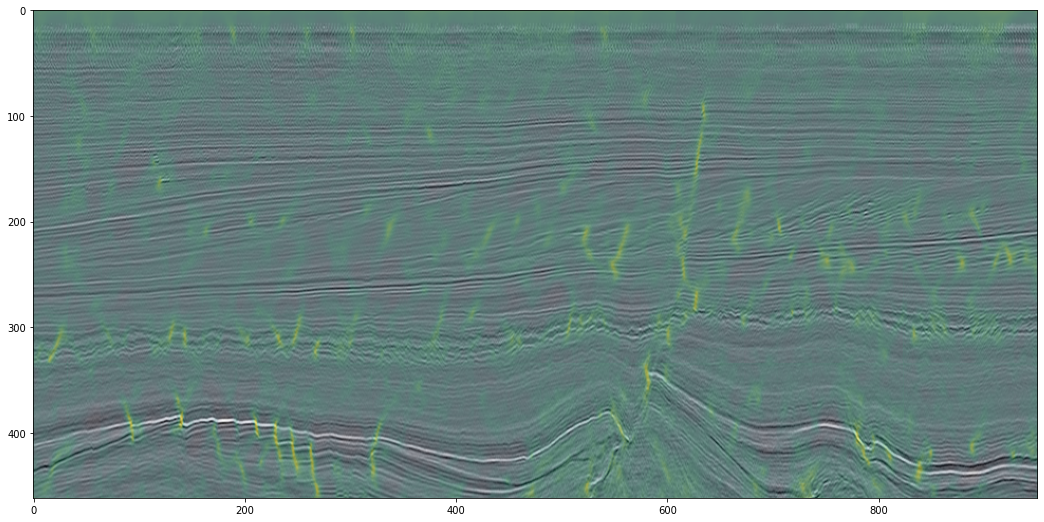

In [77]:
plt.figure(figsize=(18,18))
plt.imshow(data[200,:,:], cmap='Greys')
plt.imshow(result, cmap='viridis_alpha')
plt.show()